In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from collections import Counter, namedtuple
from sklearn.metrics import precision_recall_curve


import re
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2


from sklearn.semi_supervised import LabelSpreading
from sklearn.decomposition import TruncatedSVD
from gensim.models import Doc2Vec, Word2Vec, KeyedVectors 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier

C:\Users\1255971\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\1255971\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
data = pd.read_json('News.json', lines=True)
print(data.shape[0])
data['category'].unique()
data = data.loc[data['category'].isin(['STYLE & BEAUTY','TRAVEL','PARENTING'])].reset_index(drop=True)
print(data.shape[0])
data['conc'] = data.headline.map(str) + " " + data.short_description
data.head()

200853
28213


,authors,category,date,headline,link,short_description,conc
0,Taylor Pittman,TRAVEL,2018-05-24,"14 Ways To Make Family Road Trips Easier, From...",https://www.huffingtonpost.com/entry/family-ro...,Having waterproof covers on the seats is kind ...,"14 Ways To Make Family Road Trips Easier, From..."
1,Caroline Bologna,TRAVEL,2018-05-23,14 Trips To Take From New York City On A Long ...,https://www.huffingtonpost.com/entry/14-fun-lo...,"Charming towns, relaxing beaches and top hikin...",14 Trips To Take From New York City On A Long ...
2,Ed Mazza,TRAVEL,2018-05-23,Disney Reveals Opening Seasons For 'Star Wars'...,https://www.huffingtonpost.com/entry/disney-st...,Star Wars: Galaxy's Edge will open at Disneyla...,Disney Reveals Opening Seasons For 'Star Wars'...
3,Brittany Nims,TRAVEL,2018-05-22,Lonely Planet's Top European Destinations Of 2...,https://www.huffingtonpost.com/entry/lonely-pl...,These underrated travel destinations in Europe...,Lonely Planet's Top European Destinations Of 2...
4,"PureWow, Editorial Partner",TRAVEL,2018-05-21,8 Majestic Islands In Europe That Most Tourist...,https://www.huffingtonpost.com/entry/8-majesti...,If you’re dreaming about a romantic European g...,8 Majestic Islands In Europe That Most Tourist...


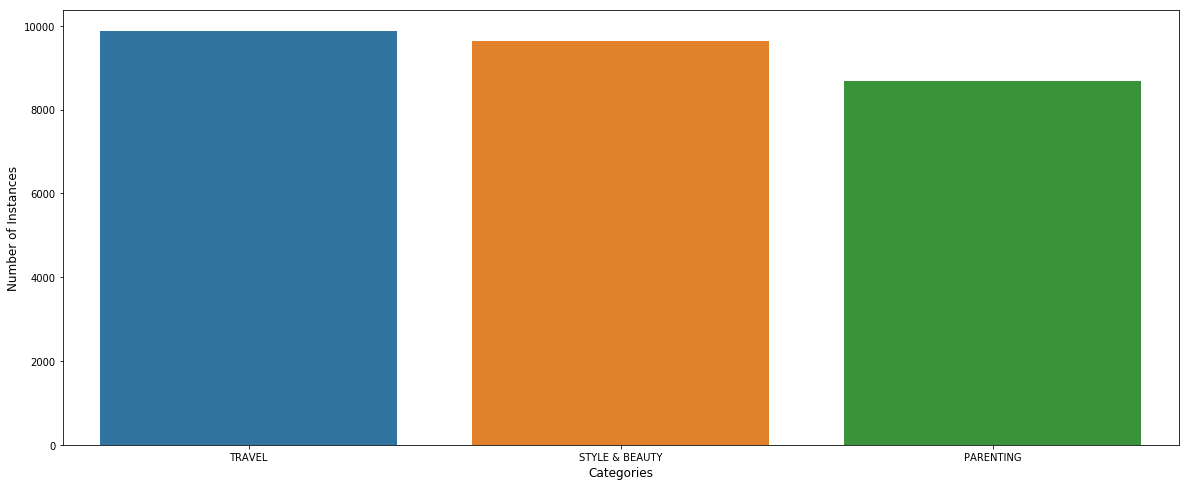

In [3]:
cnt_sents = data['category'].value_counts()
plt.figure(figsize=(20,8))
sns.barplot(cnt_sents.index, cnt_sents.values, alpha=1)
plt.ylabel('Number of Instances', fontsize=12)
plt.xlabel('Categories', fontsize=12)
plt.show()

In [4]:
def cleaning(text):
    text = re.sub(r'[^\w\s]','',text)
    tokenized = []
    words = word_tokenize(text)
    for word in words:
        p = morph.parse(word)[0]
        tokenized.append(p.normal_form)
    tokenized = [token for token in tokenized if token not in stopWords\
                and token != " " \
                and token != "—" \
                and token != "«" \
                and token != "»" \
                and token != ".." \
                and token.strip() not in punctuation]
    return tokenized

In [ ]:
texts = data['conc']
headl = data['headline']
shd = data['short_description']
labels = data['category']
morph = pymorphy2.MorphAnalyzer()
stopWords = stopwords.words('english')
cleaned_texts = texts.apply(cleaning)
cleaned_head = headl.apply(cleaning)
cleaned_shd = shd.apply(cleaning)

In [ ]:
head_train, head_test, shd_train, shd_test = train_test_split(cleaned_head, cleaned_shd, test_size=0.33, random_state=50)
texts_train, texts_test, labels_train, labels_test = train_test_split(cleaned_texts, labels, test_size=0.33, random_state=50)


In [ ]:
def counting (df):
    words = []
    dflist = df.tolist()
    for text in dflist:
        for word in text:
            words.append(word)
    fivemc = Counter(words).most_common(20)
    return fivemc
trav = data[lambda x: x['category'] == 'TRAVEL']
trav = trav['headline'].apply(cleaning)
mctrav = counting(trav)
style = data[lambda x: x['category'] == 'STYLE & BEAUTY']
style = style['headline'].apply(cleaning)
mcstyle = counting(style)
par = data[lambda x: x['category'] == 'PARENTING']
par = par['headline'].apply(cleaning)
mcpar = counting(par)

In [ ]:
print('Самые частотные слова раздела travel: ', mctrav)
print('Самые частотные слова раздела style and beauty: ', mcstyle)
print('Самые частотные слова раздела parenting: ', mcpar)

In [ ]:
def classifier (text):
    travrules = ["travel", "best", "world", "city", "hotel", "trip", "hotels", "vacation"]
    stylerules = ["style", "fashion", "look", "dress", "check", "beauty", "hair", "pinterest"]
    parrules = ["kids", "children", "parents", "child", "baby", "mom", "family", "parenting"]
    for word in text:
        if word in travrules:
            return 'TRAVEL'
        elif word in stylerules:
            return 'STYLE & BEAUTY'
        elif word in parrules:
            return 'PARENTING'
    return 'unclassified'

pred = cleaned_texts.apply(classifier)



In [ ]:
len(pred)

In [ ]:
z=0
for i in pred:
    if i == 'unclassified':
        z+=1
z

In [ ]:
print("Accuracy: ", accuracy_score(labels, pred))
print('Precision: ', precision_score(labels, pred, average ="macro"))
print("Recall: ", recall_score(labels, pred, average="macro"))

In [ ]:
numlab =[]
for i in pred:
    if i == 'unclassified':
        numlab.append(-1)
    if i == 'PARENTING':
        numlab.append(1)
    if i == 'STYLE & BEAUTY':
        numlab.append(2)
    if i == 'TRAVEL':
        numlab.append(3)

In [ ]:
docs = shaping([list(set_) for set_ in cleaned_texts.tolist()])
d2vmodel = Doc2Vec(docs, vector_size = 100, window = 300, min_count = 2, workers = 6)
d2v =[]
for i in range(0,28213):
    d2v.append(d2vmodel[i])
labeled_spr = LabelSpreading(kernel='knn')
labelsenttest = labeled_spr.fit(d2v, numlab)
labelstest = labelsenttest.transduction_

In [ ]:
semisuperlabels = []
for i in labelstest:
    if i == 1:
        semisuperlabels.append('PARENTING')
    if i == 2:
        semisuperlabels.append('STYLE & BEAUTY')
    if i == 3:
        semisuperlabels.append('TRAVEL')

In [ ]:
print("Accuracy: ", accuracy_score(labels, semisuperlabels))
print('Точность: ', precision_score(labels, semisuperlabels, average ="macro"))
print("Полнота: ", recall_score(labels, semisuperlabels, average="macro"))
print("F-мера: ", f1_score(labels, semisuperlabels, average="macro"))
cm = confusion_matrix(labels, semisuperlabels)
plot_confusion_matrix(cm, target_names=['TRAVEL', 'STYLE & BEAUTY', 'PARENTING'],
                      title='Confusion matrix of semisupervised learning based on rules')
plt.show()

In [ ]:
tetr = [' '.join(list(set_)) for set_ in texts_train.tolist()]
labtr = labels_train.tolist()
tete = [' '.join(list(set_)) for set_ in texts_test.tolist()]
textclass = Pipeline([
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf', SGDClassifier(n_iter_no_change=5, random_state=50)),
])
textclass.fit(tetr, labtr)
predclassestexts = textclass.predict(tete)

In [ ]:
hdtr = [' '.join(list(set_)) for set_ in head_train.tolist()]
hdte = [' '.join(list(set_)) for set_ in head_test.tolist()]
headclass = Pipeline([
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf', SGDClassifier(n_iter_no_change=5, random_state=50)),
])
headclass.fit(hdtr, labtr)
predclasseshead = textclass.predict(hdte)

In [ ]:
shdtr = [' '.join(list(set_)) for set_ in shd_train.tolist()]
shdte = [' '.join(list(set_)) for set_ in shd_test.tolist()]
shdclass = Pipeline([
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf', SGDClassifier(n_iter_no_change=5, random_state=50)),
])
shdclass.fit(shdtr, labtr)
predclassesshd = textclass.predict(shdte)

In [ ]:
def plot_confusion_matrix(cm, target_names,title='Confusion matrix', cmap=None, normalize=True):   
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
print("Accuracy: ", accuracy_score(labels_test, predclassestexts))
print('Точность: ', precision_score(labels_test, predclassestexts, average ="macro"))
print("Полнота: ", recall_score(labels_test, predclassestexts, average="macro"))
print("F-мера: ", f1_score(labels_test, predclassestexts, average="macro"))
cm = confusion_matrix(labels_test, predclassestexts)
plot_confusion_matrix(cm, target_names=['TRAVEL', 'STYLE & BEAUTY', 'PARENTING'],
                      title='Confusion matrix of SGDClassifier with concatenated data')
plt.show()

In [ ]:
print("Accuracy: ", accuracy_score(labels_test, predclasseshead))
print('Точность: ', precision_score(labels_test, predclasseshead, average ="macro"))
print("Полнота: ", recall_score(labels_test, predclasseshead, average="macro"))
print("F-мера: ", f1_score(labels_test, predclasseshead, average="macro"))
cm = confusion_matrix(labels_test, predclasseshead)
plot_confusion_matrix(cm, target_names=['TRAVEL', 'STYLE & BEAUTY', 'PARENTING'],
                      title='Confusion matrix of SGDClassifier with only headers')
plt.show()

In [ ]:
print("Accuracy: ", accuracy_score(labels_test, predclassesshd))
print('Точность: ', precision_score(labels_test, predclassesshd, average ="macro"))
print("Полнота: ", recall_score(labels_test, predclassesshd, average="macro"))
print("F-мера: ", f1_score(labels_test, predclassesshd, average="macro"))
cm = confusion_matrix(labels_test, predclassesshd)
plot_confusion_matrix(cm, target_names=['TRAVEL', 'STYLE & BEAUTY', 'PARENTING'],
                      title='Confusion matrix of SGDClassifier with only short desc')
plt.show()

In [ ]:
textclassdec = Pipeline([
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components = 3000)),
    ('clf', SGDClassifier(n_iter_no_change=5, random_state=179)),
])


In [ ]:
textclassdec.fit(tetr, labtr)
predclassesdec = textclassdec.predict(tete)

print('Точность: ', precision_score(labels_test, predclassesdec, average ="macro"))
print("Полнота: ", recall_score(labels_test, predclassesdec, average="macro"))
print("F-мера: ", f1_score(labels_test, predclassesdec, average="macro"))
print("Accuracy: ", accuracy_score(labels_test, predclassesdec)) 
cm = confusion_matrix(labels_test, predclassesdec)
plot_confusion_matrix(cm, target_names=['TRAVEL', 'STYLE & BEAUTY', 'PARENTING'],
                      title='Confusion matrix of SGDClassifier Rescaled')
plt.show()

In [ ]:
def shaping (rev):
    shapeddata = []
    analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
    for i, text in enumerate(rev):
        tags = [i]
        shapeddata.append(analyzedDocument(text, tags))
    return shapeddata

In [ ]:
shapedtraintexts = shaping([list(set_) for set_ in texts_train.tolist()])
d2vtr = Doc2Vec(shapedtraintexts, vector_size = 100, window = 300, min_count = 2, workers = 6)
d2vtrain =[]
for i in range(0,18902):
    d2vtrain.append(d2vtr[i])

shapedtesttexts = shaping([list(set_) for set_ in texts_test.tolist()])
d2vte = Doc2Vec(shapedtesttexts, vector_size = 100, window = 300, min_count = 2, workers = 6)
d2vtest =[]
for i in range(0,9311):
    d2vtest.append(d2vte[i])
    
trainclasses = labels_train.tolist()
testclasses = labels_test.tolist()

In [ ]:
clf = SGDClassifier(n_iter_no_change=5, random_state=179)
clf.fit(d2vtrain, trainclasses)
predcl = clf.predict(d2vtest)

In [ ]:
print('Точность: ', precision_score(testclasses, predcl, average ="macro"))
print("Полнота: ", recall_score(testclasses, predcl, average="macro"))
print("F-мера: ", f1_score(testclasses, predcl, average="macro"))
print("Accuracy: ", accuracy_score(testclasses, predcl))
cm_2 = confusion_matrix(testclasses, predcl)
plot_confusion_matrix(cm_2, target_names=['TRAVEL', 'STYLE & BEAUTY', 'PARENTING'],
                      title='Confusion matrix of SGDClassifier + D2V')
plt.show()